In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

  !ls

Saving BBB_labels.txt to BBB_labels.txt
Saving BBB_features.csv to BBB_features.csv
User uploaded file "BBB_labels.txt" with length 6110 bytes
BBB_features.csv  BBB_labels.txt  sample_data
User uploaded file "BBB_features.csv" with length 3357142 bytes
BBB_features.csv  BBB_labels.txt  sample_data


In [2]:
import re
import numpy as np
import pandas as pd

df = pd.read_csv('BBB_features.csv', sep=';')
label = pd.read_csv('BBB_labels.txt', header=None, sep=' ')
newdf = pd.DataFrame(columns=df.columns)
logbb = []
permeate = []
for molname in df['Objects']:
    basename = re.sub(r'_c0', '', molname)
    if basename in label[0].values:
        lobBB = label[label[0] == basename][1].values[0]
        logbb.append(lobBB)
        if lobBB > 0:
            permeate.append(1)
        else:
            permeate.append(0)
        newdf = pd.concat([newdf, df[df['Objects'] == molname]])
    else:
        print('removing', molname)

df = newdf

<ipython-input-2-f75cd362ee4d>:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  newdf = pd.concat([newdf, df[df['Objects'] == molname]])


removing 1,1,1,2-tetrachloroethane_c1
removing 1,1,1,2-tetrachloroethane_c2
removing 1,1,1,2-tetrachloroethane_c3
removing 1,1,1,2-tetrachloroethane_c4
removing 1,1,1,2-tetrachloroethane_c5
removing 1,1,1,2-tetrachloroethane_c6
removing 1,1,1,2-tetrachloroethane_c7
removing 1,1,1,2-tetrachloroethane_c8
removing 1,4-divinyloxybutane_c10
removing 1,4-divinyloxybutane_c11
removing 1,4-divinyloxybutane_c12
removing 1,4-divinyloxybutane_c13
removing 1,4-divinyloxybutane_c14
removing 1,4-divinyloxybutane_c15
removing 1,4-divinyloxybutane_c1
removing 1,4-divinyloxybutane_c2
removing 1,4-divinyloxybutane_c3
removing 1,4-divinyloxybutane_c4
removing 1,4-divinyloxybutane_c5
removing 1,4-divinyloxybutane_c6
removing 1,4-divinyloxybutane_c7
removing 1,4-divinyloxybutane_c8
removing 1,4-divinyloxybutane_c9
removing 1-butanol_c10
removing 1-butanol_c11
removing 1-butanol_c12
removing 1-butanol_c13
removing 1-butanol_c14
removing 1-butanol_c15
removing 1-butanol_c16
removing 1-butanol_c17
removing 1-

In [3]:
print('logBB', len(logbb))
print('permeate', len(permeate))
print(df.shape)

logBB 330
permeate 330
(330, 128)


In [4]:
X = df.drop(['Objects'], axis=1)
X = X.dropna(axis=1)
# remove constant columns
X = X.loc[:, (X != X.iloc[0]).any()]
# remove duplicate columns
X = X.T.drop_duplicates().T
y_regression = np.array(logbb)
y_classification = np.array(permeate)

print('X.shape', X.shape)
print('y_regression.shape', y_regression.shape)
print('y_classification.shape', y_classification.shape)

X.shape (330, 120)
y_regression.shape (330,)
y_classification.shape (330,)


In [5]:
# remove the highly correalted features
"""
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X = X.drop(X[to_drop], axis=1)
print('to_drop', to_drop)
print('X.shape after removing highly correlated features', X.shape)
"""

"\ncorr_matrix = X.corr().abs()\nupper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))\nto_drop = [column for column in upper.columns if any(upper[column] > 0.95)]\nX = X.drop(X[to_drop], axis=1)\nprint('to_drop', to_drop)\nprint('X.shape after removing highly correlated features', X.shape)\n"

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_regression_train, \
    y_regression_test, y_classification_train, \
    y_classification_test = \
    train_test_split(X, y_regression, y_classification, \
                     test_size=0.2, random_state=42)
print('X_train.shape', X_train.shape)
print('y_regression_train.shape', y_regression_train.shape)
print('y_classification_train.shape', y_classification_train.shape)
print('X_test.shape', X_test.shape)
print('y_regression_test.shape', y_regression_test.shape)
print('y_classification_test.shape', y_classification_test.shape)

X_train.shape (264, 120)
y_regression_train.shape (264,)
y_classification_train.shape (264,)
X_test.shape (66, 120)
y_regression_test.shape (66,)
y_classification_test.shape (66,)


In [7]:
"""
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# standadize the data first
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# It then uses this learned information to transform the data by
# subtracting the mean and dividing by the standard deviation
# of each feature.
for ncomp in range(1, 20):
    pca = PCA(n_components=ncomp)
    X_pca = pca.fit_transform(X_train)
    totalexplained = sum(pca.explained_variance_ratio_)
    print('ncomp %3d'%(ncomp), 'totalexplained %3.2f'%(totalexplained))
"""

"\nfrom sklearn.decomposition import PCA\nfrom sklearn.preprocessing import StandardScaler\n\n# standadize the data first\nscaler = StandardScaler()\nX_train = scaler.fit_transform(X_train)\nX_test = scaler.transform(X_test)\n# It then uses this learned information to transform the data by \n# subtracting the mean and dividing by the standard deviation \n# of each feature.\nfor ncomp in range(1, 20):\n    pca = PCA(n_components=ncomp)\n    X_pca = pca.fit_transform(X_train)\n    totalexplained = sum(pca.explained_variance_ratio_)\n    print('ncomp %3d'%(ncomp), 'totalexplained %3.2f'%(totalexplained))\n"

In [8]:
"""
pca = PCA(n_components=15)
pca.fit(X_train)
X_train = pca.transform(X_train)
print('X_train.shape', X_train.shape)
X_test = pca.transform(X_test)
print('X_test.shape', X_test.shape)
"""

"\npca = PCA(n_components=15)\npca.fit(X_train)\nX_train = pca.transform(X_train)\nprint('X_train.shape', X_train.shape)\nX_test = pca.transform(X_test)\nprint('X_test.shape', X_test.shape)\n"

In [9]:
print(X_train.info())


<class 'pandas.core.frame.DataFrame'>
Index: 264 entries, 979 to 1183
Columns: 120 entries, V to PAINS
dtypes: object(120)
memory usage: 249.6+ KB
None


In [17]:
import timeit
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
adam = Adam(learning_rate=0.001)
from sklearn.preprocessing import StandardScaler

# convert all X values to floating point
X_train = X_train.astype('float32')
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_test = X_test.astype('float32')
X_test = scaler.transform(X_test)

start = timeit.default_timer()

model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
# TRY TO REMOVE SOME LAYERS OR NEURONS
model.add(Dense(64, activation='relu'))
# Try to add l2 regularization
# model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.5))  # Dropout layer with a 50% dropout rate
model.add(Dense(1, activation='linear'))
model.compile(loss='mean_squared_error', \
            optimizer=adam, \
            metrics=['mse'])
X_train_np = np.array(X_train)

history = model.fit(X_train_np, y_regression_train, epochs=20, \
                    batch_size=64, verbose=1, validation_split=0.1)
endtrain = timeit.default_timer()
print('Time train %8.3f s'%(endtrain - start))

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.3285 - mse: 0.3285 - val_loss: 0.3428 - val_mse: 0.3428
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2215 - mse: 0.2215 - val_loss: 0.2984 - val_mse: 0.2984
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1780 - mse: 0.1780 - val_loss: 0.2816 - val_mse: 0.2816
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1574 - mse: 0.1574 - val_loss: 0.2646 - val_mse: 0.2646
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1365 - mse: 0.1365 - val_loss: 0.2506 - val_mse: 0.2506
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1350 - mse: 0.1350 - val_loss: 0.2488 - val_mse: 0.2488
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1079 - mse: 0.1079 - val_loss: 0.2504 - val_mse: 0.2504
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1214 - mse: 0.1214 - val_loss: 0.2498 - val_mse: 0.2498
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0932 - mse: 0.0932 - val_loss: 

min loss:  0.04508797079324722
min val_loss:  0.2059360146522522


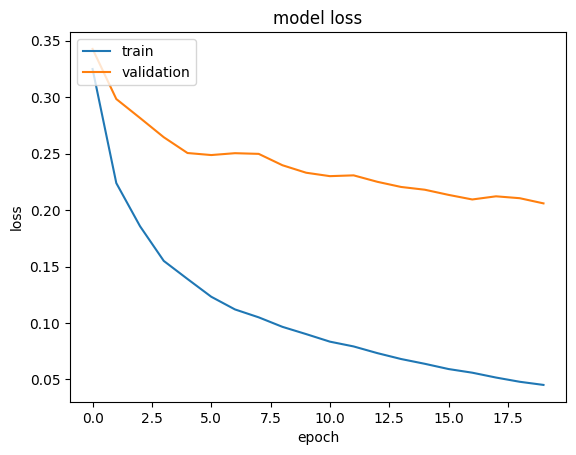

In [18]:
import matplotlib.pyplot as plt

print("min loss: ", min(history.history['loss']))
print("min val_loss: ", min(history.history['val_loss']))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
rmse:  0.4179963372705616


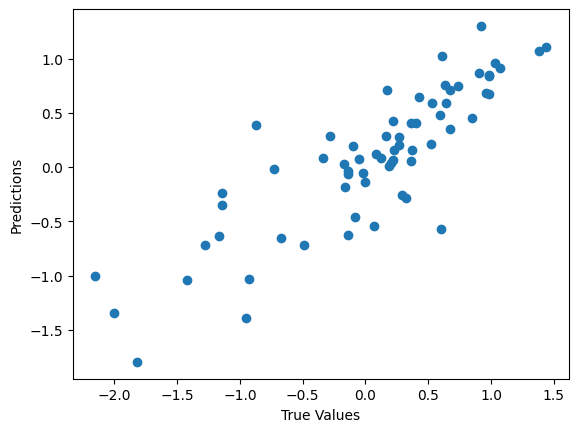

In [19]:
Y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_regression_test, Y_pred))
print('rmse: ', rmse)
plt.scatter(y_regression_test, Y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()